# Black-Litterman allocation

The Black-Litterman method is a very powerful way of converting your views on asset returns, along with your uncertainty in these views, into a portfolio.

For a description of the theory, please read the [documentation page](https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html) and the links therein.

In addition to price data, constructing a market prior requires market-caps. 

In [1]:
import yfinance as yf
from pathlib import Path
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
stock_path = Path("../Resources/stock_prices.csv")
stock_prices = pd.read_csv(stock_path, infer_datetime_format = True, parse_dates = True, index_col = "Date")

In [3]:
crypto_path = Path("../Resources/crypto_prices.csv")
crypto_prices = pd.read_csv(crypto_path, infer_datetime_format = True, parse_dates = True, index_col = "Date")

In [4]:
market_prices = stock_prices['SPY']
stock_prices.drop(columns = 'SPY', inplace = True)
prices = stock_prices.join(crypto_prices)

In [5]:
market_path = Path("../Resources/market_caps.csv")
market_caps = pd.read_csv(market_path)

In [6]:
prices.head()

,AMC,AMD,BABA,BB,BBBY,GME,MVIS,NVDA,TSLA,BTC,BCH,ETH,ETC,LTC,XRP,DOGE
Date,,,,,,,,,,,,,,,,
2017-08-01,16.469416,13.71,154.729996,9.51,26.660824,17.939491,2.25,162.812164,63.914001,2718.26,380.01,226.77,14.57,43.04,0.18,0.001792
2017-08-02,12.035346,13.37,151.910004,9.50,26.421677,17.956287,2.31,162.713196,65.178001,2710.67,452.66,219.95,14.77,42.13,0.17,0.001788
2017-08-03,11.956165,13.24,153.320007,9.42,27.050552,18.191450,2.45,164.781860,69.417999,2804.73,364.05,225.34,15.37,42.86,0.17,0.001795
2017-08-04,12.866734,13.12,153.330002,9.44,26.660824,18.418217,2.47,165.504440,71.382004,2895.89,233.05,223.07,15.04,43.45,0.17,0.001820
2017-08-07,12.747964,13.43,158.839996,9.10,27.139126,18.619781,2.52,170.591980,71.033997,3378.94,319.69,269.18,15.31,45.80,0.18,0.001949


In [7]:
mcaps = dict(market_caps.values)

In [8]:
del mcaps['SPY']

In [9]:
mcaps

{'GME': 14821737472.0,
 'AMC': 7389094912.0,
 'TSLA': 582516000000.0,
 'BB': 4814926848.0,
 'NVDA': 374079000000.0,
 'BBBY': 2531467520.0,
 'MVIS': 2468789760.0,
 'BABA': 574829000000.0,
 'AMD': 94601461760.0,
 'BTC': 763196000000.0,
 'BCH': 15398498102.0,
 'ETH': 322857000000.0,
 'ETC': 8613669767.0,
 'LTC': 14169944716.0,
 'XRP': 54695173849.0,
 'DOGE': 51897302336.0}

## Constructing the prior

In [10]:
import pypfopt
pypfopt.__version__

'1.4.1'

In [11]:
from pypfopt import black_litterman, risk_models
from pypfopt import BlackLittermanModel, plotting

S = risk_models.CovarianceShrinkage(prices).ledoit_wolf()
delta = black_litterman.market_implied_risk_aversion(market_prices)
delta

3.581424530527258

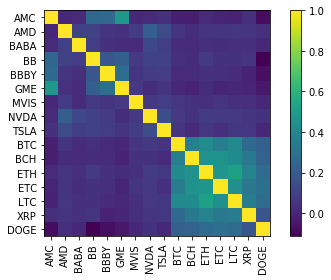

In [12]:
plotting.plot_covariance(S, plot_correlation=True);

In [13]:
market_prior = black_litterman.market_implied_prior_returns(mcaps, delta, S)
market_prior

AMC     0.119993
AMD     0.332124
BABA    0.482378
BB      0.207036
BBBY    0.163940
GME     0.183613
MVIS    0.275904
NVDA    0.503221
TSLA    0.700524
BTC     1.157901
BCH     0.933709
ETH     1.106595
ETC     0.847919
LTC     0.934931
XRP     0.884940
DOGE    1.088490
dtype: float64

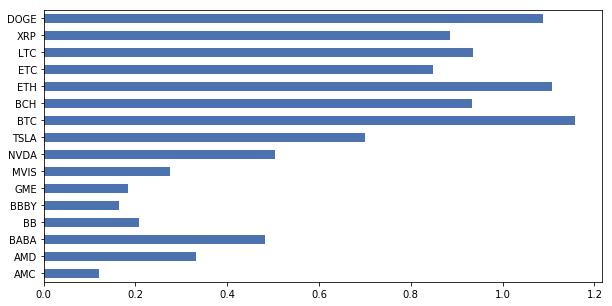

In [14]:
market_prior.plot.barh(figsize=(10,5));

## Views

In the BL method, views are specified via the matrix P (picking matrix) and the vector Q. Q contains the magnitude of each view, while P maps the views to the assets they belong to. 

If you are providing **absolute views** (i.e a return estimate for each asset), you don't have to worry about P and Q, you can just pass your views as a dictionary.

In [ ]:
# You don't have to provide views on all the assets
viewdict = {
    "AMZN": 0.10,
    "BAC": 0.30,
    "COST": 0.05,
    "DIS": 0.05,
    "DPZ": 0.20,
    "KO": -0.05,  # I think Coca-Cola will go down 5%
    "MCD": 0.15,
    "MSFT": 0.10,
    "NAT": 0.50,  # but low confidence, which will be reflected later
    "SBUX": 0.10
}

bl = BlackLittermanModel(S, pi=market_prior, absolute_views=viewdict)

In [ ]:
#     SBUX will drop 20% (absolute)
#     MSFT will rise by 5% (absolute)
#     GOOG outperforms FB by 10%
#     BAC and JPM will outperform T and GE by 15%

# Q = np.array([-0.20, 0.05, 0.10, 0.15]).reshape(-1, 1)

# P = np.array(
#     [
#         [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
#         [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
#         [0, 1, -1, 0, 0, 0, 0, 0, 0, 0],
#         [0, 0, 0, 0, 0.5, 0.5, -0.5, -0.5, 0, 0],
#     ]
# )


In [22]:
# BTC will rise by 10%
# GME will outperform NVDA by 20%
# ETH will outperform ETC by 5%
# BB will fall 20%

Q = np.array([0.1, 0.2, 0.05, 0.2]).reshape(-1, 1)

P = np.array(
    [
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,0],
        [0, 0, 0, 0, 0, 1, 0, -1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, -1, 0, 0,0],
        [0, 0, 0, -1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    ]
)

Black-Litterman also allows for relative views, e.g you think asset A will outperform asset B by 10%. If you'd like to incorporate these, you will have to build P and Q yourself. An explanation for this is given in the [docs](https://pyportfolioopt.readthedocs.io/en/latest/BlackLitterman.html#views).

## View confidences

In this section, we provide two ways that you may wish to construct the uncertainty matrix. The first is known as Idzorek's method. It allows you to specify a vector/list of percentage confidences.

In [ ]:
confidences = [
    0.6,
    0.4,
    0.2,
    0.5,
    0.7, # confident in dominos
    0.7, # confident KO will do poorly
    0.7, 
    0.5,
    0.1,
    0.4
]

In [16]:
confidences = [
    0.6,
    0.4,
    0.3,
    0.2
]

In [23]:
bl = BlackLittermanModel(S, pi=market_prior, view_confidences = confidences, omega="idzorek", Q = Q, P = P)

In [18]:
bl.omega

array([[0.02900924, 0.        , 0.        , 0.        ],
       [0.        , 0.19773586, 0.        , 0.        ],
       [0.        , 0.        , 0.16442631, 0.        ],
       [0.        , 0.        , 0.        , 0.14142133]])

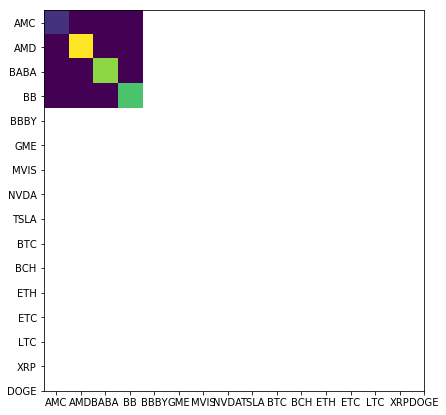

In [19]:
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(bl.omega)

# We want to show all ticks...
ax.set_xticks(np.arange(len(bl.tickers)))
ax.set_yticks(np.arange(len(bl.tickers)))

ax.set_xticklabels(bl.tickers)
ax.set_yticklabels(bl.tickers)
plt.show()

In [20]:
np.diag(bl.omega)

array([0.02900924, 0.19773586, 0.16442631, 0.14142133])

Note how NAT, which we gave the lowest confidence, also has the highest uncertainty.

Instead of inputting confidences, we can calculate the uncertainty matrix directly by specifying 1 standard deviation confidence intervals, i.e bounds which we think will contain the true return 68% of the time. This may be easier than coming up with somewhat arbitrary percentage confidences

In [ ]:
intervals = [
    (0, 0.25),
    (0.1, 0.4),
    (-0.1, 0.15),
    (-0.05, 0.1),
    (0.15, 0.25),
    (-0.1, 0),
    (0.1, 0.2),
    (0.08, 0.12),
    (0.1, 0.9),
    (0, 0.3)
]

In [ ]:
variances = []
for lb, ub in intervals:
    sigma = (ub - lb)/2
    variances.append(sigma ** 2)

print(variances)
omega = np.diag(variances)

## Posterior estimates

Given the inputs, we can compute a posterior estimate of returns


In [ ]:
# We are using the shortcut to automatically compute market-implied prior
bl = BlackLittermanModel(S, pi="market", market_caps=mcaps, risk_aversion=delta,
                        absolute_views=viewdict, omega=omega)

In [24]:
# Posterior estimate of returns
ret_bl = bl.bl_returns()
ret_bl

AMC     0.211630
AMD     0.295700
BABA    0.465005
BB      0.192077
BBBY    0.134683
GME     0.326357
MVIS    0.220357
NVDA    0.423363
TSLA    0.664406
BTC     0.520891
BCH     0.591399
ETH     0.764825
ETC     0.594190
LTC     0.599540
XRP     0.631717
DOGE    0.769755
dtype: float64

We can visualise how this compares to the prior and our views:

In [25]:
rets_df = pd.DataFrame([market_prior, ret_bl], 
             index=["Prior", "Posterior"]).T
rets_df

,Prior,Posterior
AMC,0.119993,0.211630
AMD,0.332124,0.295700
BABA,0.482378,0.465005
BB,0.207036,0.192077
BBBY,0.163940,0.134683
GME,0.183613,0.326357
MVIS,0.275904,0.220357
NVDA,0.503221,0.423363
TSLA,0.700524,0.664406
BTC,1.157901,0.520891


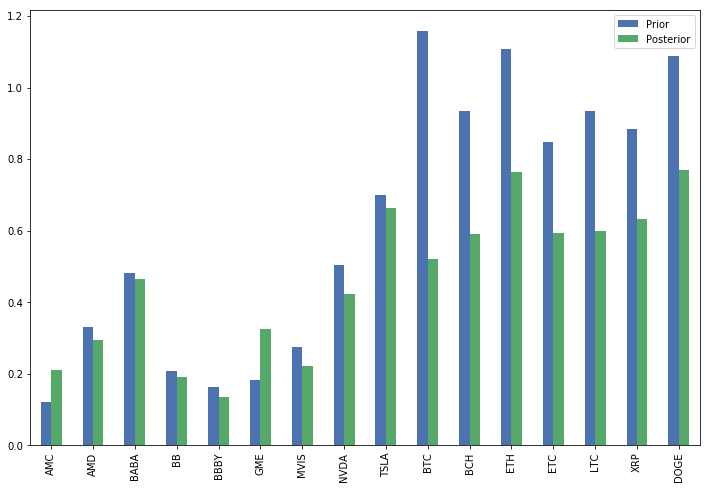

In [26]:
rets_df.plot.bar(figsize=(12,8));

Notice that the posterior is often between the prior and the views. This supports the fact that the BL method is essentially a Bayesian weighted-average of the prior and views, where the weight is determined by the confidence.

A similar but less intuitive procedure can be used to produce the posterior covariance estimate:

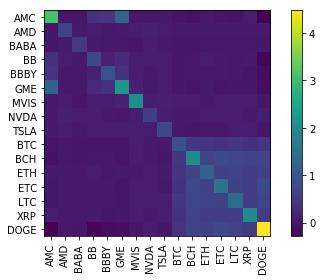

In [27]:
S_bl = bl.bl_cov()
plotting.plot_covariance(S_bl);

## Portfolio allocation

Now that we have constructed our Black-Litterman posterior estimate, we can proceed to use any of the optimizers discussed in previous recipes.

In [29]:
from pypfopt import EfficientFrontier, objective_functions

In [30]:
ef = EfficientFrontier(ret_bl, S_bl)
ef.add_objective(objective_functions.L2_reg)
ef.max_sharpe()
weights = ef.clean_weights()
weights

C:\Users\Victor\anaconda3\envs\pyvizenv\lib\site-packages\pypfopt\efficient_frontier\efficient_frontier.py:248: UserWarning: max_sharpe transforms the optimization problem so additional objectives may not work as expected.
  "max_sharpe transforms the optimization problem so additional objectives may not work as expected."


OrderedDict([('AMC', 0.00946),
             ('AMD', 0.05808),
             ('BABA', 0.1525),
             ('BB', 0.02382),
             ('BBBY', 0.00581),
             ('GME', 0.04158),
             ('MVIS', 0.01469),
             ('NVDA', 0.1093),
             ('TSLA', 0.19151),
             ('BTC', 0.07672),
             ('BCH', 0.02865),
             ('ETH', 0.11277),
             ('ETC', 0.04219),
             ('LTC', 0.04218),
             ('XRP', 0.04909),
             ('DOGE', 0.04166)])

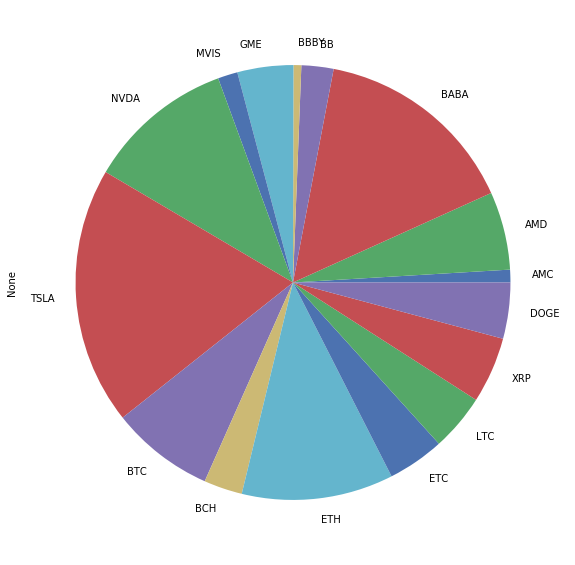

In [31]:
pd.Series(weights).plot.pie(figsize=(10,10));

In [32]:
from pypfopt import DiscreteAllocation

da = DiscreteAllocation(weights, prices.iloc[-1], total_portfolio_value=20000)
alloc, leftover = da.lp_portfolio()
print(f"Leftover: ${leftover:.2f}")
alloc

Leftover: $13.18


{'AMC': 16,
 'AMD': 15,
 'BABA': 15,
 'BB': 55,
 'BBBY': 5,
 'GME': 5,
 'MVIS': 21,
 'NVDA': 4,
 'TSLA': 7,
 'BCH': 1,
 'ETH': 1,
 'ETC': 12,
 'LTC': 4,
 'XRP': 826,
 'DOGE': 2083}

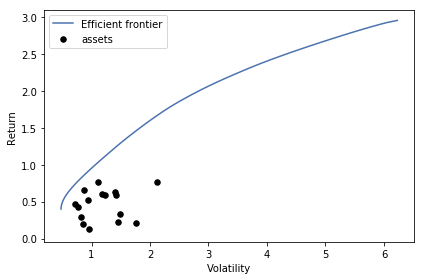

In [33]:
ef = EfficientFrontier(ret_bl, S_bl, weight_bounds=(None, None))
ef.add_constraint(lambda w: w[0] >= 0.2)
ef.add_constraint(lambda w: w[2] == 0.15)
ef.add_constraint(lambda w: w[3] + w[4] <= 0.10)

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=True)
plt.show()

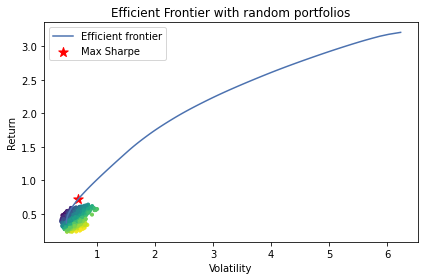

In [55]:
fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find the tangency portfolio
ef.max_sharpe()
ret_tangent, std_tangent, _ = ef.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# # Generate random portfolios
n_samples = 10000
w = np.random.dirichlet(np.ones(len(ret_bl)), n_samples)
rets = w.dot(ret_bl)
stds = np.sqrt(np.diag(w @ S @ w.T))
sharpes = rets / stds
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Output
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.savefig("ef_scatter.png", dpi=200)
plt.show()

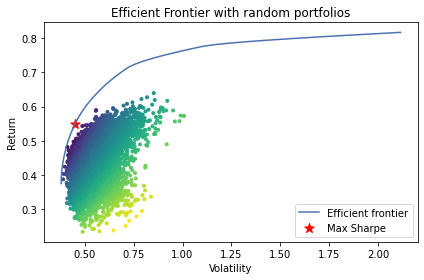

In [58]:
ef = EfficientFrontier(ret_bl, S_bl)

fig, ax = plt.subplots()
plotting.plot_efficient_frontier(ef, ax=ax, show_assets=False)

# Find and plot the tangency portfolio
ef.max_sharpe()
ret_tangent, std_tangent, _ = ef.portfolio_performance()
ax.scatter(std_tangent, ret_tangent, marker="*", s=100, c="r", label="Max Sharpe")

# Plot random portfolios
ax.scatter(stds, rets, marker=".", c=sharpes, cmap="viridis_r")

# Format
ax.set_title("Efficient Frontier with random portfolios")
ax.legend()
plt.tight_layout()
plt.show()
